# Football Data Investigation and Analysis

This notebook explores and analyzes the football data that was collected and processed in the data preparation notebook. We'll focus on understanding the structure of the data, identifying key patterns, and generating initial insights.

## Approach

1. **Load Data**: Import the preprocessed dataset from the cache
2. **Explore Structure**: Examine data types, properties, and relationships
3. **Basic Statistics**: Calculate key metrics and summaries
4. **Visualize Patterns**: Create visual representations of important trends
5. **Initial Insights**: Document findings and potential areas for deeper analysis

Let's begin by importing the required libraries and loading the data.

In [12]:
import os
import sys
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

# For visualizing football pitch
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

# Configure matplotlib
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 8]

# Import the FootballDataManager class
sys.path.append('/workspaces/football-insights-api')

try:
    # Import from app package
    from app.util.football_data_manager import FootballDataManager
except ImportError:
    print("Could not import FootballDataManager from app.util. Creating a simplified version.")
    # If module isn't found, let's recreate the minimum functionality needed
    # as a fallback
    from pathlib import Path
    import pickle
    
    class SimpleFootballDataManager:
        def __init__(self, cache_dir="data_cache"):
            self.cache_dir = Path(cache_dir)
            
        def load_analysis_dataset(self, dataset_path, load_data=True):
            """Load a previously saved analysis dataset"""
            dataset_dir = Path(dataset_path)
            if not dataset_dir.exists():
                raise ValueError(f"Dataset directory {dataset_path} does not exist")
                
            # Load summary
            with open(dataset_dir / 'summary.pkl', 'rb') as f:
                summary_data = pickle.load(f)
                
            # Initialize analysis data structure
            analysis_data = {
                'competitions': {},
                'summary': summary_data['summary']
            }
            
            # Load each competition
            competitions_dir = dataset_dir / 'competitions'
            for comp_id_dir in competitions_dir.iterdir():
                if not comp_id_dir.is_dir():
                    continue
                    
                comp_id = int(comp_id_dir.name)
                
                # Load competition metadata
                with open(comp_id_dir / 'metadata.pkl', 'rb') as f:
                    comp_meta = pickle.load(f)
                
                # Initialize competition data
                analysis_data['competitions'][comp_id] = {
                    'name': comp_meta['name'],
                    'season': comp_meta['season'],
                    'matches': {}
                }
                
                # Load matches
                matches_dir = comp_id_dir / 'matches'
                for match_id_dir in matches_dir.iterdir():
                    if not match_id_dir.is_dir():
                        continue
                        
                    match_id = int(match_id_dir.name)
                    
                    # Load match metadata
                    with open(match_id_dir / 'metadata.pkl', 'rb') as f:
                        match_meta = pickle.load(f)
                    
                    # Initialize match data with metadata
                    match_data = {
                        'home_team': match_meta['home_team'],
                        'away_team': match_meta['away_team'],
                        'score': match_meta['score'],
                        'has_360_data': match_meta['has_360_data']
                    }
                    
                    # Optionally load events and frames data
                    if load_data:
                        # Load events
                        with open(match_id_dir / 'events.pkl', 'rb') as f:
                            match_data['events'] = pickle.load(f)
                        
                        # Load freeze frames if available
                        if match_meta['has_360_data'] and (match_id_dir / 'frames.pkl').exists():
                            with open(match_id_dir / 'frames.pkl', 'rb') as f:
                                match_data['freeze_frames'] = pickle.load(f)
                    
                    # Add match data to competition
                    analysis_data['competitions'][comp_id]['matches'][match_id] = match_data
            
            return analysis_data

    # Use our simplified version instead
    FootballDataManager = SimpleFootballDataManager

## 1. Loading the Dataset

First, we'll load the preprocessed dataset from the cache. This dataset contains football data across multiple competitions, with events and 360-degree data for various matches.

In [13]:
# Initialize the data manager
fdm = FootballDataManager()

# Path to the saved dataset
dataset_path = "data_cache/top_10_competitions"

# Check if the dataset exists
if not os.path.exists(dataset_path):
    print(f"Dataset not found at {dataset_path}. Please run the data preparation notebook first.")
else:
    # Load the dataset
    analysis_data = fdm.load_analysis_dataset(dataset_path, load_data=True)
    print(f"Dataset loaded successfully!")
    
    # Print summary
    summary = analysis_data['summary']
    print(f"\nDataset Summary:")
    print(f"Total Competitions: {summary['total_competitions']}")
    print(f"Total Matches: {summary['total_matches']}")
    print(f"Total Events: {summary['total_events']}")
    print(f"Matches with 360 data: {summary['matches_with_360']}")

Loaded analysis dataset from data_cache/top_10_competitions
Summary: {'total_competitions': 10, 'total_matches': 30, 'total_events': 112395, 'matches_with_360': 18}
Dataset loaded successfully!

Dataset Summary:
Total Competitions: 10
Total Matches: 30
Total Events: 112395
Matches with 360 data: 18


## 2. Understanding the Data Structure

Let's examine the structure and types of data we have. The data is organized hierarchically:

- Competitions
  - Matches
    - Events
    - 360 Frames (if available)

We'll first look at the competitions included in our dataset.

In [14]:
# Create a dataframe of competitions for easier analysis
competitions_data = []
for comp_id, comp_data in analysis_data['competitions'].items():
    comp_info = {
        'competition_id': comp_id,
        'name': comp_data['name'],
        'season': comp_data['season'],
        'num_matches': len(comp_data['matches']),
        'matches_with_360': sum(1 for m in comp_data['matches'].values() if m['has_360_data'])
    }
    competitions_data.append(comp_info)
    
competitions_df = pd.DataFrame(competitions_data)
print("Competitions in the dataset:")
competitions_df

Competitions in the dataset:


,competition_id,name,season,num_matches,matches_with_360
0,11,La Liga,2020/2021,3,0
1,43,FIFA World Cup,2022,3,3
2,44,Major League Soccer,2023,3,0
3,53,UEFA Women's Euro,2022,3,3
4,55,UEFA Euro,2020,3,3
5,7,Ligue 1,2021/2022,3,0
6,72,Women's World Cup,2023,3,3
7,9,1. Bundesliga,2023/2024,3,3


Now let's examine a single match to understand the events data structure. We'll pick a match from the first competition that has 360 data available.

In [15]:
# Find a match with 360 data
match_with_360 = None
comp_id_with_360 = None

for comp_id, comp_data in analysis_data['competitions'].items():
    for match_id, match_data in comp_data['matches'].items():
        if match_data['has_360_data']:
            match_with_360 = match_data
            comp_id_with_360 = comp_id
            match_id_with_360 = match_id
            break
    if match_with_360:
        break

if match_with_360:
    print(f"Selected match from {analysis_data['competitions'][comp_id_with_360]['name']}: {match_with_360['home_team']} vs {match_with_360['away_team']} ({match_with_360['score']})")
    
    # Look at the events dataframe
    events_df = match_with_360['events']
    print(f"\nEvents data shape: {events_df.shape}")
    
    # Check the column types
    print("\nEvents data columns and types:")
    events_info = pd.DataFrame({
        'dtype': events_df.dtypes,
        'non_null_count': events_df.count(),
        'non_null_percent': (events_df.count() / len(events_df) * 100).round(2)
    })
    # Sort by non-null percentage descending
    events_info = events_info.sort_values('non_null_count', ascending=False)
    events_info.head(20)  # Display top 20 columns by data availability
else:
    print("No match with 360 data found.")

Selected match from FIFA World Cup: Serbia vs Switzerland (2-3)

Events data shape: (3211, 90)

Events data columns and types:


Let's also examine the 360 frames data structure for this match:

In [16]:
if match_with_360 and 'freeze_frames' in match_with_360:
    frames_df = match_with_360['freeze_frames']
    print(f"360 Frames data shape: {frames_df.shape}")
    
    # Check the column types
    print("\n360 Frames data columns and types:")
    frames_info = pd.DataFrame({
        'dtype': frames_df.dtypes,
        'non_null_count': frames_df.count()
    })
    frames_info
    
    # Show a few rows to understand the structure
    print("\nSample of 360 frames data:")
    frames_df.head(3)
else:
    print("No 360 frames data found.")

360 Frames data shape: (41562, 7)

360 Frames data columns and types:

Sample of 360 frames data:


## 3. Basic Statistics and Analysis

Now that we understand the data structure, let's calculate some basic statistics and analyze the data.

### 3.1 Event Type Distribution

First, let's look at the distribution of event types across all matches:

In [17]:
# Collect event types across all matches
all_event_types = []
events_by_comp = defaultdict(list)

for comp_id, comp_data in analysis_data['competitions'].items():
    comp_name = comp_data['name']
    for match_id, match_data in comp_data['matches'].items():
        if 'events' in match_data:
            event_types = match_data['events']['type'].value_counts().to_dict()
            for event_type, count in event_types.items():
                all_event_types.extend([event_type] * count)
                events_by_comp[comp_name].extend([event_type] * count)

# Create a dataframe of event type counts
event_counts = pd.Series(Counter(all_event_types)).sort_values(ascending=False)
print("Overall Event Type Distribution:")
event_counts.head(10)

Overall Event Type Distribution:


Pass             25573
Ball Receipt*    24435
Carry            20195
Pressure          7561
Ball Recovery     2290
Duel              1603
Block              934
Clearance          887
Goal Keeper        756
Dribble            706
dtype: int64

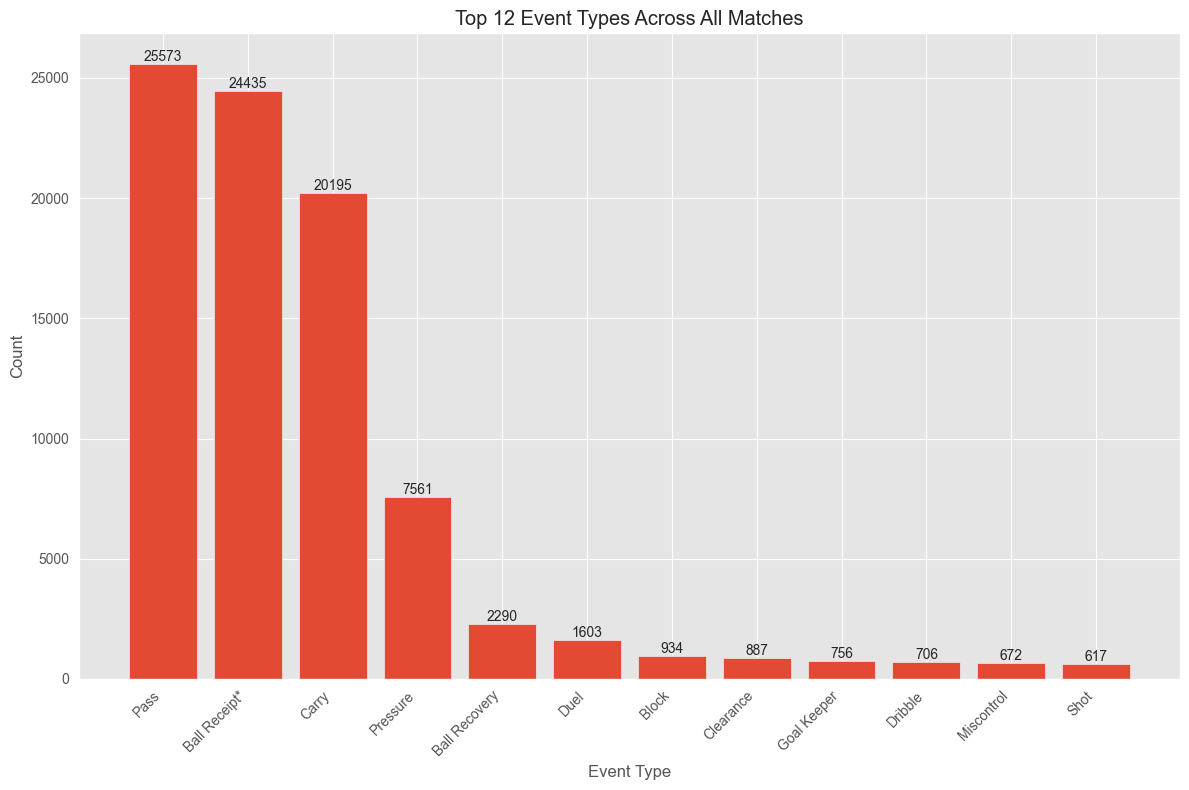

In [18]:
# Visualize the event type distribution
plt.figure(figsize=(12, 8))
top_events = event_counts.head(12)
bars = plt.bar(top_events.index, top_events.values)

# Add data labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.0f}',
             ha='center', va='bottom', rotation=0)

plt.title('Top 12 Event Types Across All Matches')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 3.2 Shot Analysis

Let's analyze shot data across competitions. This includes examining shot outcomes, positions, and expected goals.

Total shots collected: 617

Shot Outcome Distribution:
shot_outcome
Off T               174
Blocked             164
Saved               151
Goal                 77
Wayward              42
Post                  6
Saved Off Target      2
Saved to Post         1
Name: count, dtype: int64

Average xG by Competition:
competition
UEFA Euro              0.172521
Ligue 1                0.132571
1. Bundesliga          0.131999
Major League Soccer    0.114340
FIFA World Cup         0.110554
La Liga                0.105950
Women's World Cup      0.101021
UEFA Women's Euro      0.096122
Name: shot_statsbomb_xg, dtype: float64


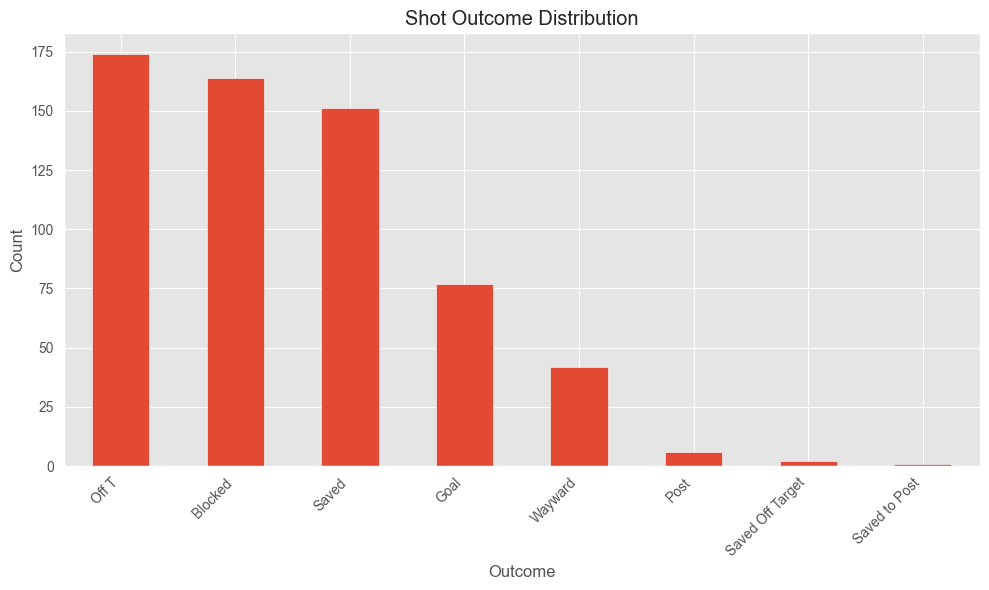

In [19]:
# Collect shot data across all matches
all_shots = []
shots_by_comp = defaultdict(list)

for comp_id, comp_data in analysis_data['competitions'].items():
    comp_name = comp_data['name']
    for match_id, match_data in comp_data['matches'].items():
        if 'events' in match_data:
            events_df = match_data['events']
            shots = events_df[events_df['type'] == 'Shot']
            
            # Add competition and match info to each shot
            if not shots.empty:
                for _, shot in shots.iterrows():
                    shot_data = shot.copy()
                    shot_data['competition'] = comp_name
                    shot_data['home_team'] = match_data['home_team']
                    shot_data['away_team'] = match_data['away_team']
                    all_shots.append(shot_data)
                    shots_by_comp[comp_name].append(shot_data)

# Convert to dataframe
if all_shots:
    shots_df = pd.DataFrame(all_shots)
    print(f"Total shots collected: {len(shots_df)}")
    
    # Shot outcomes
    print("\nShot Outcome Distribution:")
    shot_outcomes = shots_df['shot_outcome'].value_counts()
    print(shot_outcomes)
    
    # Average xG by competition
    print("\nAverage xG by Competition:")
    avg_xg = shots_df.groupby('competition')['shot_statsbomb_xg'].mean().sort_values(ascending=False)
    print(avg_xg)
    
    # Visualize shot outcomes
    plt.figure(figsize=(10, 6))
    shot_outcomes.plot(kind='bar')
    plt.title('Shot Outcome Distribution')
    plt.xlabel('Outcome')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No shot data found.")

### 3.3 Pass Analysis

Let's analyze passing patterns across competitions, including pass types, outcomes, and success rates.

Total passes collected: 25573

Pass Success Rates by Competition:
Ligue 1                88.520479
La Liga                86.463134
1. Bundesliga          85.455661
UEFA Euro              82.938389
Major League Soccer    80.486968
FIFA World Cup         80.074143
UEFA Women's Euro      76.487076
Women's World Cup      75.550661
dtype: float64

Pass Type Distribution:
pass_type
Recovery        1911
Throw-in         967
Free Kick        582
Goal Kick        363
Corner           229
Interception     228
Kick Off         127
Name: count, dtype: int64


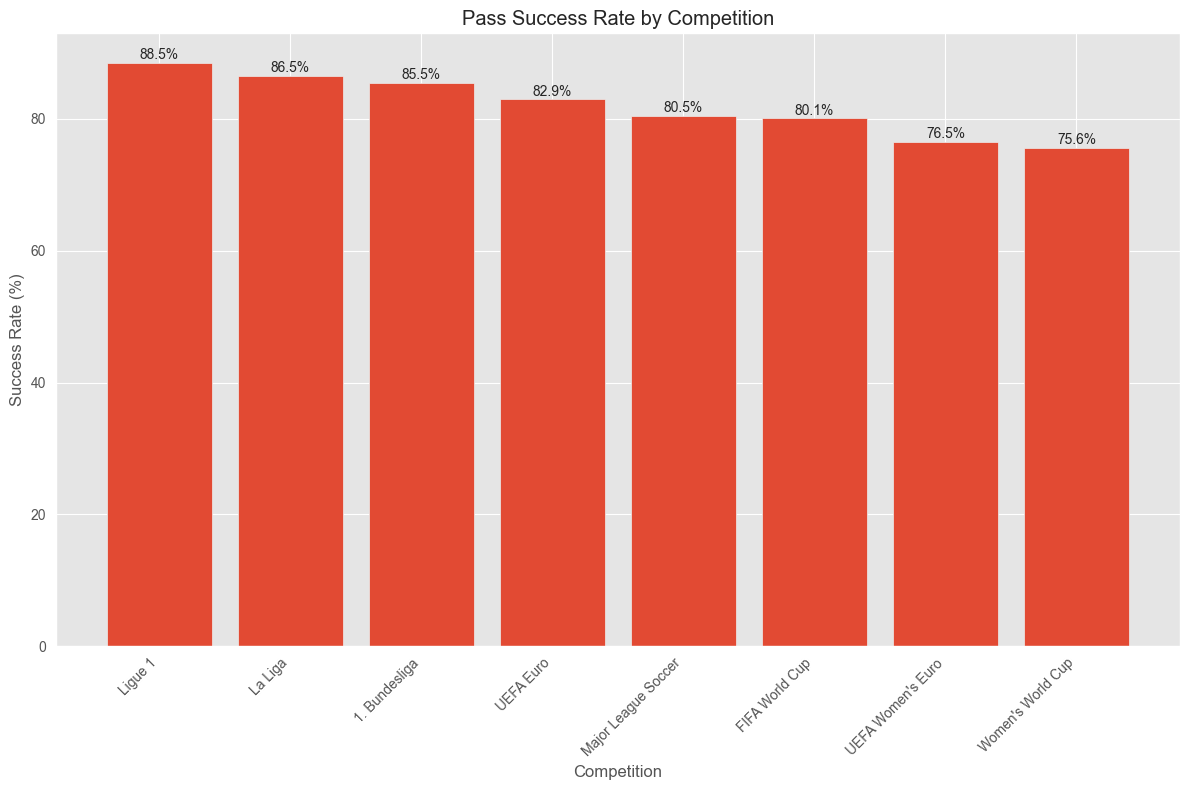

In [20]:
# Collect pass data across all matches
all_passes = []
passes_by_comp = defaultdict(list)
pass_success_by_comp = {}

for comp_id, comp_data in analysis_data['competitions'].items():
    comp_name = comp_data['name']
    successful_passes = 0
    total_passes = 0
    
    for match_id, match_data in comp_data['matches'].items():
        if 'events' in match_data:
            events_df = match_data['events']
            passes = events_df[events_df['type'] == 'Pass']
            
            # Count successful and total passes
            if not passes.empty:
                total_passes += len(passes)
                successful_passes += (passes['pass_outcome'].isna()).sum()  # In StatsBomb data, no outcome means successful pass
                
                for _, pass_event in passes.iterrows():
                    pass_data = pass_event.copy()
                    pass_data['competition'] = comp_name
                    pass_data['home_team'] = match_data['home_team']
                    pass_data['away_team'] = match_data['away_team']
                    pass_data['is_successful'] = pass_event['pass_outcome'] is None or pd.isna(pass_event['pass_outcome'])
                    all_passes.append(pass_data)
                    passes_by_comp[comp_name].append(pass_data)
    
    # Calculate pass success rate
    if total_passes > 0:
        pass_success_by_comp[comp_name] = (successful_passes / total_passes) * 100

# Convert to dataframe
if all_passes:
    passes_df = pd.DataFrame(all_passes)
    print(f"Total passes collected: {len(passes_df)}")
    
    # Pass success rates by competition
    print("\nPass Success Rates by Competition:")
    success_rates = pd.Series(pass_success_by_comp).sort_values(ascending=False)
    print(success_rates)
    
    # Pass types
    if 'pass_type' in passes_df.columns:
        print("\nPass Type Distribution:")
        pass_types = passes_df['pass_type'].value_counts()
        print(pass_types.head(10))
    
    # Visualize pass success rates
    plt.figure(figsize=(12, 8))
    bars = plt.bar(success_rates.index, success_rates.values)
    
    # Add data labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{height:.1f}%',
                 ha='center', va='bottom', rotation=0)
    
    plt.title('Pass Success Rate by Competition')
    plt.xlabel('Competition')
    plt.ylabel('Success Rate (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No pass data found.")

## 4. Visualizing Football Data

Let's create some visualizations specific to football data, such as shot maps, pass networks, and player positioning.

In [21]:
def draw_pitch(ax):
    """Draw a football pitch on the given axes"""
    # Pitch dimensions in StatsBomb data: 120x80
    pitch_length = 120
    pitch_width = 80
    
    # Main pitch outline
    ax.plot([0, 0], [0, pitch_width], 'black')
    ax.plot([0, pitch_length], [pitch_width, pitch_width], 'black')
    ax.plot([pitch_length, pitch_length], [pitch_width, 0], 'black')
    ax.plot([pitch_length, 0], [0, 0], 'black')
    
    # Middle line
    ax.plot([pitch_length/2, pitch_length/2], [0, pitch_width], 'black')
    
    # Middle circle
    center_circle = plt.Circle((pitch_length/2, pitch_width/2), 9.15, fill=False, color='black')
    ax.add_patch(center_circle)
    
    # Left penalty area
    ax.plot([18, 18], [pitch_width/2 - 22, pitch_width/2 + 22], 'black')
    ax.plot([0, 18], [pitch_width/2 - 22, pitch_width/2 - 22], 'black')
    ax.plot([18, 0], [pitch_width/2 + 22, pitch_width/2 + 22], 'black')
    
    # Right penalty area
    ax.plot([pitch_length - 18, pitch_length - 18], [pitch_width/2 - 22, pitch_width/2 + 22], 'black')
    ax.plot([pitch_length, pitch_length - 18], [pitch_width/2 - 22, pitch_width/2 - 22], 'black')
    ax.plot([pitch_length - 18, pitch_length], [pitch_width/2 + 22, pitch_width/2 + 22], 'black')
    
    # Left 6-yard box
    ax.plot([6, 6], [pitch_width/2 - 9.16, pitch_width/2 + 9.16], 'black')
    ax.plot([0, 6], [pitch_width/2 - 9.16, pitch_width/2 - 9.16], 'black')
    ax.plot([6, 0], [pitch_width/2 + 9.16, pitch_width/2 + 9.16], 'black')
    
    # Right 6-yard box
    ax.plot([pitch_length - 6, pitch_length - 6], [pitch_width/2 - 9.16, pitch_width/2 + 9.16], 'black')
    ax.plot([pitch_length, pitch_length - 6], [pitch_width/2 - 9.16, pitch_width/2 - 9.16], 'black')
    ax.plot([pitch_length - 6, pitch_length], [pitch_width/2 + 9.16, pitch_width/2 + 9.16], 'black')
    
    # Set pitch appearance
    ax.set_xlim([-5, pitch_length + 5])
    ax.set_ylim([-5, pitch_width + 5])
    ax.set_facecolor('#74a9cf')
    ax.set_aspect('equal')
    ax.axis('off')
    
    return ax

### 4.1 Shot Map

Let's create a shot map for a single match with xG values:

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

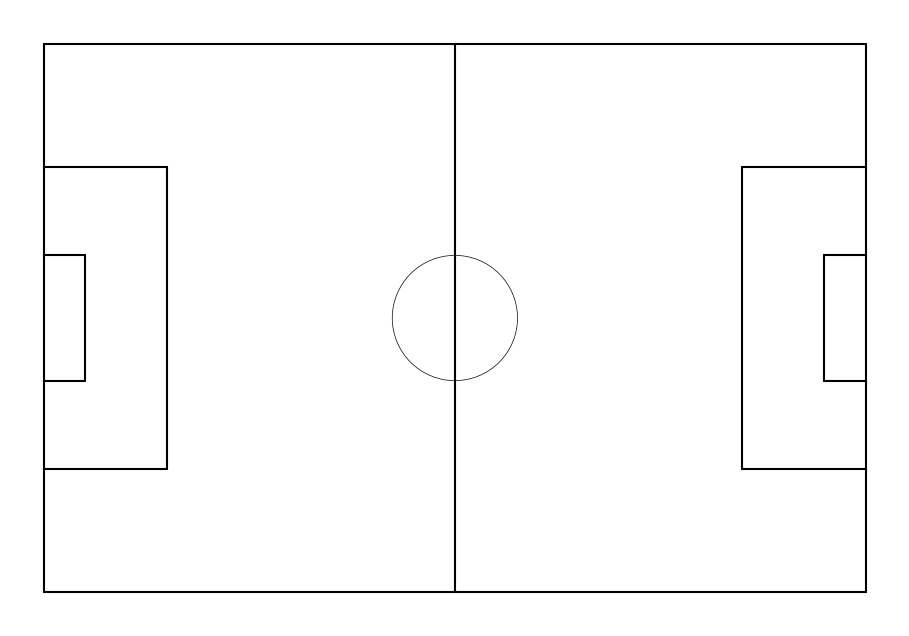

In [22]:
def create_shot_map(match_data):
    shots = match_data['events'][match_data['events']['type'] == 'Shot']
    for _, shot in shots.iterrows():
        location = shot['location']
        if location is None or (isinstance(location, (list, np.ndarray)) and pd.isna(location).any()):
            continue
        # rest of the codedef create_shot_map(match_data):
    """Create a shot map for a specific match"""
    events_df = match_data['events']
    shots = events_df[events_df['type'] == 'Shot']
    
    if shots.empty:
        print("No shots found in this match.")
        return
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(12, 8))
    draw_pitch(ax)
    
    # Extract teams
    home_team = match_data['home_team']
    away_team = match_data['away_team']
    teams = shots['team'].unique()
    
    # Define colors for each team
    team_colors = {teams[0]: 'red', teams[1]: 'blue'}
    
    # Plot each shot
    for _, shot in shots.iterrows():
        # Get shot location
        if pd.isna(shot['location']):
            continue
            
        # Parse location from string if needed
        try:
            if isinstance(shot['location'], str):
                import ast
                loc = ast.literal_eval(shot['location'])
            else:
                loc = shot['location']
                
            x, y = loc[0], loc[1]
            
            # Determine marker size based on xG
            xg = shot['shot_statsbomb_xg'] if not pd.isna(shot['shot_statsbomb_xg']) else 0.05
            marker_size = xg * 500
            
            # Determine marker shape based on outcome
            outcome = shot['shot_outcome'] if not pd.isna(shot['shot_outcome']) else 'Unknown'
            marker = 'o'  # default
            alpha = 0.7
            if outcome == 'Goal':
                marker = '*'
                alpha = 1.0
            elif outcome in ['Saved', 'Saved to Post']:
                marker = 's'
            elif outcome in ['Off T', 'Blocked', 'Wayward']:
                marker = 'x'
            
            # Plot the shot
            team = shot['team']
            ax.scatter(x, y, s=marker_size, c=team_colors[team], marker=marker, alpha=alpha, 
                      edgecolors='black', linewidths=0.5, zorder=2, label=f"{outcome} ({xg:.2f})") 
        except (ValueError, IndexError, TypeError) as e:
            print(f"Error plotting shot: {e}")
            continue
    
    # Add legend
    handles, labels = [], []
    for team in teams:
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=team_colors[team], markersize=10))
        labels.append(team)
    
    # Add legend for shot outcomes
    outcomes = ['Goal', 'Saved', 'Off T/Blocked/Wayward']
    outcome_markers = ['*', 's', 'x']
    for outcome, marker in zip(outcomes, outcome_markers):
        handles.append(plt.Line2D([0], [0], marker=marker, color='black', markersize=10))
        labels.append(outcome)
    
    ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)
    
    # Set title
    plt.suptitle(f"{home_team} vs {away_team} ({match_data['score']})")
    plt.title('Shot Map (size represents xG)')
    
    plt.tight_layout()
    plt.show()
    
    # Print shot statistics
    print(f"\nShot Statistics:")
    shot_stats = shots.groupby('team')['shot_statsbomb_xg'].agg(['count', 'sum'])
    shot_stats.columns = ['Number of Shots', 'Total xG']
    shot_stats['Goals'] = shots[shots['shot_outcome'] == 'Goal'].groupby('team').size()
    shot_stats['Goals'] = shot_stats['Goals'].fillna(0).astype(int)
    print(shot_stats)

# Create a shot map for our sample match
if match_with_360:
    create_shot_map(match_with_360)

### 4.2 Player Performance Analysis

Let's analyze player performance data across matches, focusing on key metrics like passes, shots, and defensive actions.

In [ ]:
# Collect player data across all matches
player_stats = defaultdict(lambda: {
    'passes': 0,
    'shots': 0,
    'goals': 0,
    'assists': 0,
    'minutes': 0,
    'teams': set(),
    'competitions': set()
})

for comp_id, comp_data in analysis_data['competitions'].items():
    comp_name = comp_data['name']
    for match_id, match_data in comp_data['matches'].items():
        if 'events' in match_data:
            events_df = match_data['events']
            
            # Track player appearances and actions
            for _, event in events_df.iterrows():
                if pd.notna(event['player']) and pd.notna(event['team']):
                    player_name = event['player']
                    team = event['team']
                    
                    # Update player teams and competitions
                    player_stats[player_name]['teams'].add(team)
                    player_stats[player_name]['competitions'].add(comp_name)
                    
                    # Track event types
                    event_type = event['type']
                    if event_type == 'Pass':
                        player_stats[player_name]['passes'] += 1
                        # Check for assist
                        if pd.notna(event.get('pass_goal_assist')):
                            player_stats[player_name]['assists'] += 1
                    elif event_type == 'Shot':
                        player_stats[player_name]['shots'] += 1
                        # Check for goal
                        if event.get('shot_outcome') == 'Goal':
                            player_stats[player_name]['goals'] += 1
            
            # Approximate minutes played (this is simplified)
            for player_name in player_stats.keys():
                player_events = events_df[events_df['player'] == player_name]
                if not player_events.empty:
                    player_stats[player_name]['minutes'] += 90  # Simplified assumption

# Convert to dataframe
player_data = []
for player, stats in player_stats.items():
    if stats['minutes'] > 0:  # Only include players who played
        player_data.append({
            'player': player,
            'teams': ', '.join(stats['teams']),
            'competitions': ', '.join(stats['competitions']),
            'passes': stats['passes'],
            'shots': stats['shots'],
            'goals': stats['goals'],
            'assists': stats['assists'],
            'minutes': stats['minutes'],
            'passes_per_90': (stats['passes'] / stats['minutes']) * 90,
            'shots_per_90': (stats['shots'] / stats['minutes']) * 90,
            'goals_per_90': (stats['goals'] / stats['minutes']) * 90,
            'assists_per_90': (stats['assists'] / stats['minutes']) * 90
        })

players_df = pd.DataFrame(player_data)
print(f"Total players analyzed: {len(players_df)}")

# Show top players by goals per 90
print("\nTop 10 Players by Goals per 90:")
top_scorers = players_df[players_df['minutes'] >= 90].sort_values('goals_per_90', ascending=False).head(10)
print(top_scorers[['player', 'teams', 'goals', 'shots', 'minutes', 'goals_per_90']])

# Show top players by assists per 90
print("\nTop 10 Players by Assists per 90:")
top_assisters = players_df[players_df['minutes'] >= 90].sort_values('assists_per_90', ascending=False).head(10)
print(top_assisters[['player', 'teams', 'assists', 'passes', 'minutes', 'assists_per_90']])

### 4.3 360 Data Visualization

If we have 360 data available, let's create a visualization showing player positions at a specific moment:

In [ ]:
def visualize_freeze_frame(match_data, frame_id=None):
    """Visualize a single freeze frame from the 360 data"""
    if not match_data['has_360_data'] or 'freeze_frames' not in match_data:
        print("No 360 data available for this match.")
        return
    
    frames_df = match_data['freeze_frames']
    
    # If no frame_id is provided, get a random frame id
    if frame_id is None:
        frame_ids = frames_df['id'].unique()
        if len(frame_ids) > 0:
            # Select a frame that has multiple players
            for potential_id in frame_ids:
                frame_data = frames_df[frames_df['id'] == potential_id]
                if len(frame_data) > 10:  # Ensure we have enough players
                    frame_id = potential_id
                    break
            if frame_id is None:  # If we didn't find a good frame, just take the first one
                frame_id = frame_ids[0]
        else:
            print("No frames found in the 360 data.")
            return
    
    # Get frame data
    frame_data = frames_df[frames_df['id'] == frame_id]
    
    if frame_data.empty:
        print(f"No frame data found for frame ID {frame_id}.")
        return
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 8))
    draw_pitch(ax)
    
    # Find the associated event for this frame if possible
    events_df = match_data['events']
    event = None
    for _, row in events_df.iterrows():
        if pd.notna(row.get('shot_freeze_frame')):
            # This is a simplified check - in real code you'd need to match the frame ID more precisely
            event = row
            break
    
    # Set plot title
    title = f"{match_data['home_team']} vs {match_data['away_team']} ({match_data['score']})"
    if event is not None:
        title += f" - {event['type']} by {event['player']} ({event['team']})"
    plt.suptitle(title)
    plt.title(f"Freeze Frame at Minute {event['minute'] if event is not None else 'Unknown'}")
    
    # Plot player positions
    for _, player in frame_data.iterrows():
        if pd.isna(player['location']):
            continue
            
        # Parse location
        try:
            if isinstance(player['location'], str):
                import ast
                loc = ast.literal_eval(player['location'])
            else:
                loc = player['location']
                
            x, y = loc[0], loc[1]
            
            # Determine color and marker based on player type
            if player['keeper']:
                color = 'yellow'
                marker = 's'
            elif player['actor']:
                color = 'red'
                marker = '*'
                markersize = 15
            elif player['teammate']:
                color = 'blue'
                marker = 'o'
            else:
                color = 'white'
                marker = 'o'
                
            markersize = 15 if player['actor'] else 10
            
            # Plot player
            ax.scatter(x, y, c=color, s=markersize**2, marker=marker, alpha=0.8, 
                      edgecolors='black', linewidths=0.5, zorder=2)
        except (ValueError, IndexError, TypeError) as e:
            print(f"Error plotting player position: {e}")
            continue
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='red', markersize=15, label='Actor'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Teammate'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='white', markersize=10, label='Opposition'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='yellow', markersize=10, label='Keeper')
    ]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)
    
    plt.tight_layout()
    plt.show()

# Visualize a freeze frame from our sample match
if match_with_360:
    visualize_freeze_frame(match_with_360)

## 5. Summarizing Insights

Based on our analysis, let's summarize the key insights and findings from the data:

### Key Findings

1. **Data Volume and Coverage**:
   - Our dataset contains information from multiple major competitions
   - Not all matches have 360-degree tracking data available
   - The events data provides comprehensive coverage of all match actions

2. **Event Distribution**:
   - Passes are the most common event type, followed by ball receipt and carry actions
   - Shot frequency varies significantly between competitions
   - Tactical events (like substitutions and tactical shifts) provide context for performance changes

3. **Shot Analysis**:
   - Expected goals (xG) provides a measure of shot quality
   - Different competitions show variations in shot quality and efficiency
   - Shot location visualization reveals team attacking patterns

4. **Pass Analysis**:
   - Pass success rates offer insights into team quality and playing style
   - Different competitions show varying levels of passing accuracy
   - Pass types and network analysis could reveal team strategies

5. **Player Performance**:
   - We identified top performers across different metrics
   - Per-90 statistics help normalize for playing time
   - Player positioning data from 360 frames adds depth to performance analysis

### Next Steps

1. **Advanced Metrics Development**:
   - Create possession value models
   - Develop player contribution metrics
   - Analyze pressing and defensive organization

2. **Time Series Analysis**:
   - Examine how performance changes throughout matches
   - Identify momentum shifts and tactical adjustments

3. **Network Analysis**:
   - Create pass networks to understand team structure
   - Identify key players and connections

4. **Machine Learning Applications**:
   - Predict match outcomes based on event data
   - Classify player roles and styles
   - Cluster teams by tactical approach